## This notebook creates figures 3-10

It works with the code that has interception as well as the correct burn in stuff. 

In [1]:
## import packages
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean 

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

In [2]:
## Figures that don't require model runs

## Figure 1. Map - made in QGIS
## Figure 2. Jacobson Farm time series

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.9343848966822587
m 0.027663781543337797
b -0.663913202486896


<Figure size 600x400 with 0 Axes>

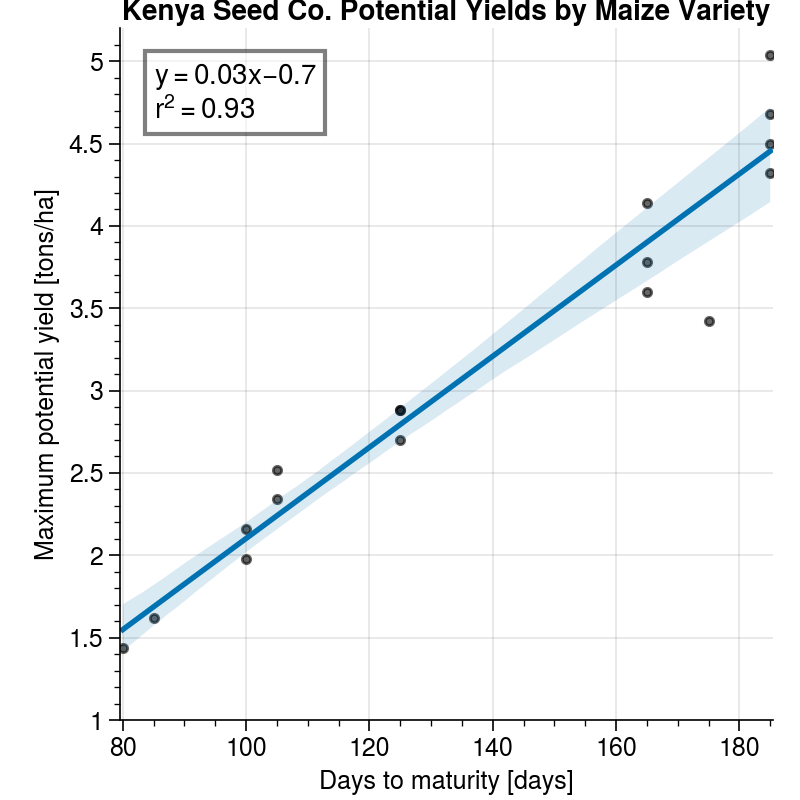

In [3]:
## Figure 3. Kenya Seed Company Figure
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = False):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        col = 'black'
        
        plt.figure(figsize=(6,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6}) # ,, line_kws={'color': 'black'}

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

        # place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.ylim(1,5.2)
        plt.title(title, fontweight="bold")
        plt.subplots_adjust(bottom=0.1, left=0.15, wspace=0.5)

        return R_squared, m, b
    
def fig3_varieties():
    # verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data

    # convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    

    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 5, 'Days to maturity [days]', 'Maximum potential yield [tons/ha]', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig3_varieties()
#plt.savefig('../output/high-res-figures/fig3_ksc.png',dpi=600)
#plt.savefig('../output/high-res-figures/fig3_ksc.pdf')

Laikipia station data was inputted.
0.78


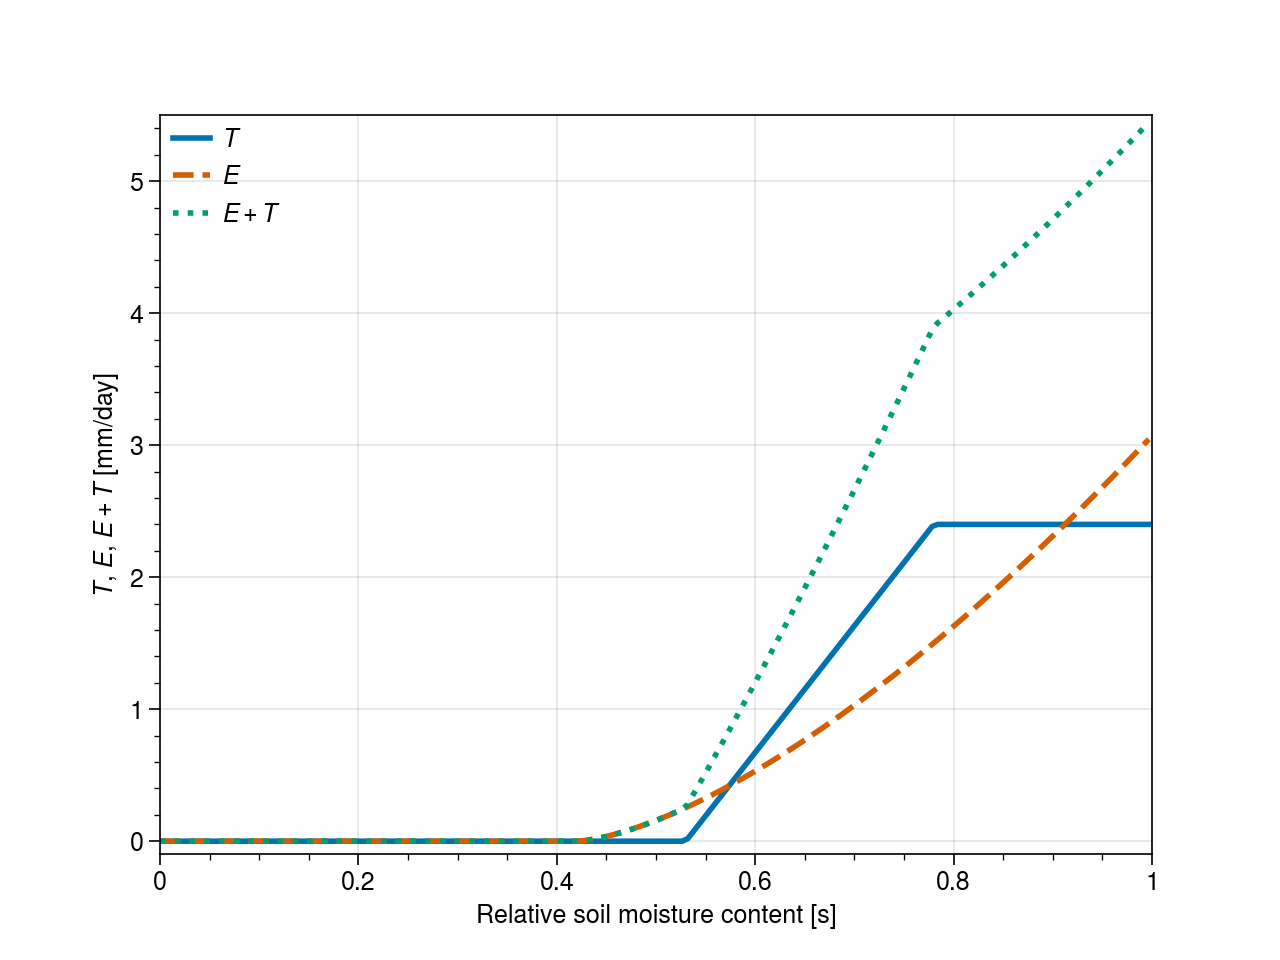

In [4]:
## Figure 4. Time series of T, E, and E+T

# Set OL JOGI climatology for the following figures
station = 'OL JOGI FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})
climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        alpha_r = a_mid,
        lambda_r = l_mid,
        #alpha_r=[100]*37, lambda_r=[0.5]*37, # This isn't affected because it's just changing the initial soil moisture?
        do_std=False) # This should be false, always
    
    
    
soil = Soil('clay loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()

# Set saturation variable
s = np.arange(0, 1, 0.0056) #saturation

def fig4_s_et(s, lai):
    plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s], '-', linewidth=2)
    plt.plot(s, [climate.calc_E(x, LAI=lai, sh=0.42) for x in s],'--', linewidth=2)
    plt.plot(s, [crop.calc_T(x, LAI=lai) + climate.calc_E(x, LAI=lai, sh=0.42) for x in s],':', linewidth=2)

    #plt.title('E, T, and ET as functions of relative soil moisture \n where LAI is %s' %lai)
    plt.xlabel('Relative soil moisture content [s]') # $\mathit{s}
    plt.ylabel('$\mathit{T}$, $\mathit{E}$, $\mathit{E+T}$ [mm/day]') # $\mathit{mm/d}$
    plt.legend(['$\mathit{T}$', '$\mathit{E}$','$\mathit{E+T}$'], frameon=False)
    plt.ylim(-0.1,5.5)
    plt.xlim(0,1)
    plt.savefig('../output/high-res-figures-2/fig4_ET.pdf')
    plt.savefig('../output/high-res-figures-2/fig4_ET.png', dpi=600)

fig4_s_et(s, lai=1.5)
print(crop.s_star)

In [5]:
## Figures that do require model runs

In [6]:
## Fig 5. Three figures to show non-stationarity

In [10]:
# this is the original version
def run(alpha_r=None, lambda_r=None, n_sim = 10000, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad', do_std=True):
    """ Set up model conditions for model runs. 
    
    Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
        interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = pd_sim - burn_in
    pd_sim = pd_sim
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        alpha_r = alpha_r,
        lambda_r = lambda_r,
        #alpha_r=[100]*37, lambda_r=[0.5]*37, # This isn't affected because it's just changing the initial soil moisture?
        do_std=False) # This should be false, always
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    model.run()
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=pd_sim) # changed this
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate( # Changed this 
                      alpha_r = alpha_r, # this can be either s0_climate.alpha_r or just alpha_r, doesnt really matter
                      lambda_r = lambda_r,
                      #alpha_r=alpha_r, #previously s0_climate.alpha_r, 
                      # when I changed alpha_r to [100]*37, this definitely changed things!!!
                      #lambda_r=lambda_r, #s0_climate.lambda_r, # [0.5]*37,
                      lambda_std=s0_climate.lambda_std,
                      do_std=True),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, planting_date=pd_sim)) # t_before=burn_in was removed
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    # This is new:
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output] # Made a change here, I dont think this makes a diff.
    
    print("Step 5: \n\t...Subsetting data to growing period.")
     
    # Part 6. Output the dynamic stress and yield values
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output] # Made a change here
    
    rf = [df[start:end]['R'].sum() for df in output] # made a change here
    
    return x, rf, int(lgp), avg_s, output, crop, station, texture, pd_sim, n_sim, burn_in, start, end

In [11]:
# # this is the version to use for the artificial s0
# def run(alpha_r=None, lambda_r=None, n_sim = 10000, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
#     texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad', do_std=True):
#     """ Set up model conditions for model runs. 
    
#     Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
#     Default values:
#         n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
#         burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
#         station = 'OL JOGI FARM' # Climatology [string]
#         texture = 'clay loam' # Soil Type [string]
#         lgp = 180 # Length of Growing Period [days]
#         pd_sim 100 # Planting Date for Simulation [day of year]
#         data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
#         interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

#     """
#     ## Step 1: Run model
#     # Part 1. Set conditions for IC runs
#     doy = pd_sim - burn_in
#     while doy < 1:
#         doy = 365 + doy
    
#     print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
#         doy=doy,
#         burn_in=burn_in,
#         pd_sim=pd_sim)
#     )
    
#     # Part 2. Initialize model with a climate, soil and crop
#     print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
#         interval=interval,
#         station=station,
#         data_file=data_file)
#     )
    
#     s0_climate = Climate(
#         data_file=data_file,
#         station=station,
#         interval=interval,
#         alpha_r = alpha_r,
#         lambda_r = lambda_r,
#         #alpha_r=[100]*37, lambda_r=[0.5]*37, # This isn't affected because it's just changing the initial soil moisture?
#         do_std=False) # This should be false, always
    
#     print("\t...Initializing soil as {texture}".format(texture=texture))
#     soil = Soil(texture=texture)
    
#     print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
#     crop = Crop(soil=soil, lgp=lgp)
    
#     print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
#     soil.set_nZr(crop)
#     model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
#     # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
#     n_burn_in_sims = max(10, int(n_sim*.10))
#     print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
#         n_burn_in_sims=n_burn_in_sims)
#     )
    
#     print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
#         doy=doy,
#         n_sim=n_burn_in_sims)
#     )
#     s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy, t_before=burn_in) # t_before was added
#     print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
#         s0_mean=s0_mean,
#         s0_std=s0_std)
#     )
#     models = [CropModel(
#                   crop=crop,
#                   climate=Climate( # this one is affected. 
#                       alpha_r = s0_climate.alpha_r, # this can be either s0_climate.alpha_r or just alpha_r, doesnt really matter
#                       lambda_r = s0_climate.lambda_r,
#                       #alpha_r=alpha_r, #previously s0_climate.alpha_r, 
#                       # when I changed alpha_r to [100]*37, this definitely changed things!!!
#                       #lambda_r=lambda_r, #s0_climate.lambda_r, # [0.5]*37,
#                       lambda_std=s0_climate.lambda_std,
#                       do_std=True),
#                   soil=soil) for i in np.arange(n_sim)
#                ]
    
#     # Part 4. Run the actual simulations 
#     print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
#     # We imported printProgressBar from functions.py earlier:
#     printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
#     output = []
#     for i, model in enumerate(models):
#         output.append(model.run(s0=s0_mean, do_output=True, planting_date=pd_sim, t_before=burn_in)) # t_before=burn_in was removed
#         printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
#     #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

#     print("\t... Done.")

#     # Part 5. Subset the growing period and get avg soil moisture
#     # This is new:
#     start = burn_in 
#     end = start + lgp
#     avg_s = [df[start:end]['s'].mean() for df in output] # Made a change here, I dont think this makes a diff.
    
#     print("Step 5: \n\t...Subsetting data to growing period.")
     
#     # Part 6. Output the dynamic stress and yield values
#     print("Step 6: \n\t...Calculating plant stress.")

#     x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output] # Made a change here
    
#     rf = [df[start:end]['R'].sum() for df in output] # made a change here
    
#     return x, rf, int(lgp), avg_s, output, crop, station, texture, pd_sim, n_sim, burn_in, start, end

In [13]:
x, rf, lgp, avg_s, output_orig, crop, station, texture, pd_sim, n_sim, burn_in, start, end = run(n_sim=10000,
                                                                                                alpha_r=a_mid,
                                                                                                lambda_r=l_mid)

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.4251064166298656	[s0_std]:0.08859900431953288
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [14]:
output_orig[10][60:240]
#output_orig[11][60:240]
#output_orig[11][0:61]

,kc,LAI,stress,R,s,I,E,ET,T,L,dsdt,dos,doy
60,0.300000,0.75,0.998899,0.0,0.530138,0.0,0.369670,0.370331,0.000661,0.0,-0.370331,1.0,60
61,0.300000,0.75,1.000000,0.0,0.528193,0.0,0.359921,0.359921,0.000000,0.0,-0.359921,2.0,61
62,0.300000,0.75,1.000000,0.0,0.526302,0.0,0.350530,0.350530,0.000000,0.0,-0.350530,3.0,62
63,0.300000,0.75,1.000000,0.0,0.524461,0.0,0.341463,0.341463,0.000000,0.0,-0.341463,4.0,63
64,0.300000,0.75,1.000000,0.0,0.522668,0.0,0.332708,0.332708,0.000000,0.0,-0.332708,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.655556,3.00,0.692228,0.0,0.571999,0.0,0.194577,1.000964,0.806387,0.0,-1.000964,176.0,235
236,0.641667,3.00,0.727663,0.0,0.566742,0.0,0.184570,0.890020,0.705449,0.0,-0.890020,177.0,236
237,0.627778,3.00,0.759912,0.0,0.562068,0.0,0.175822,0.791521,0.615700,0.0,-0.791521,178.0,237
238,0.613889,3.00,0.789180,0.0,0.557911,0.0,0.168161,0.704043,0.535882,0.0,-0.704043,179.0,238


In [15]:
# what is the average interception?
#output_orig
int_sums = []
for i in np.arange(0,len(output_orig)):
    _int_sums = sum(output_orig[i]['I'])
    int_sums.append(_int_sums)


Text(0.5, 1.0, 'Interception Histogram')

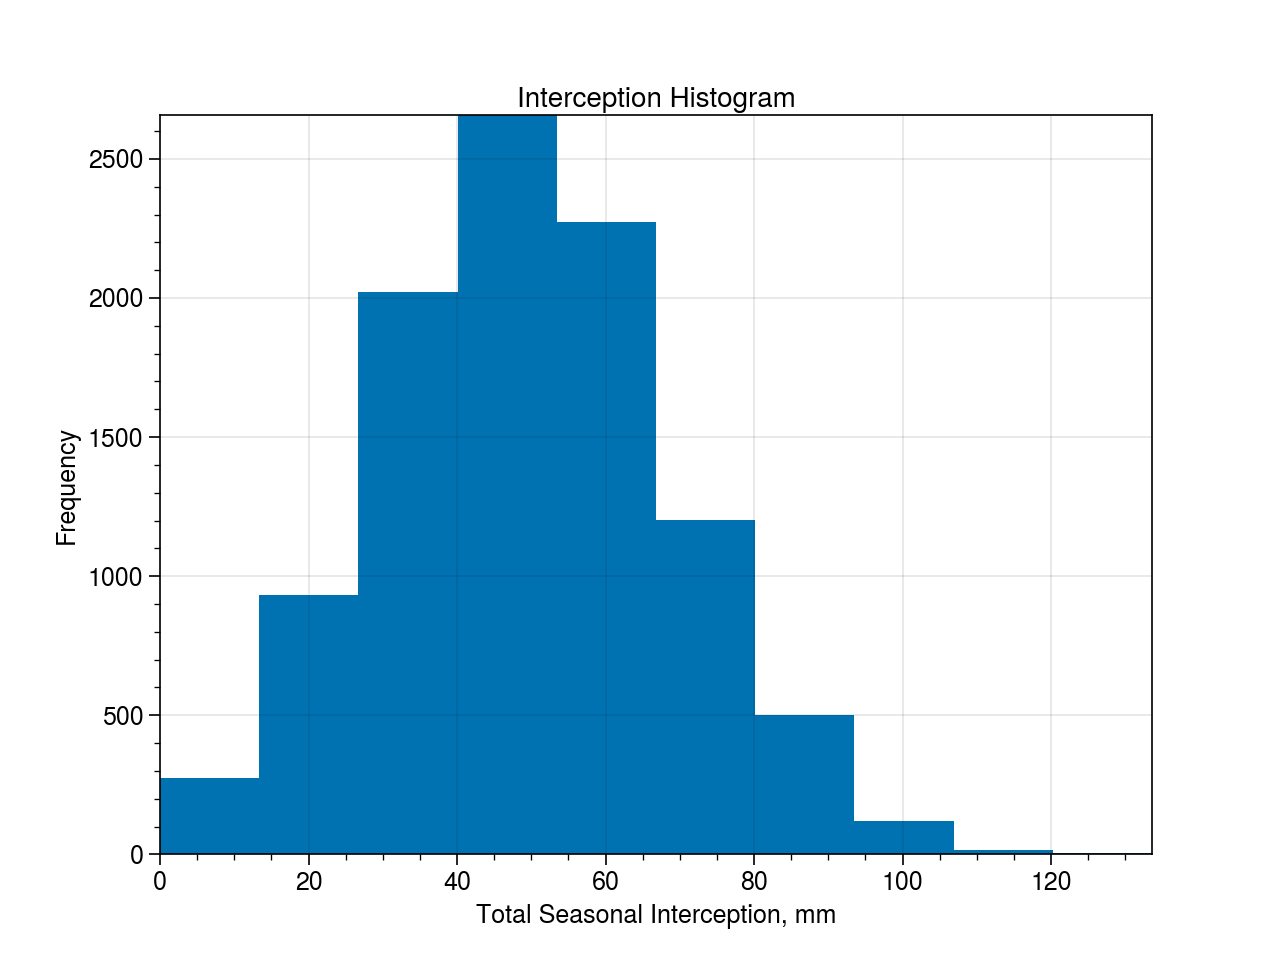

In [16]:
plt.hist(int_sums)
plt.xlabel('Total Seasonal Interception, mm')
plt.ylabel('Frequency')
plt.title('Interception Histogram')

In [17]:
# export the simulations

n_sim = 10000
no_sims = np.arange(0,n_sim)

# export simulations
for i in no_sims:
    output_orig[i][start:end].to_csv('../output/revisions/sims.3.23.21/%s.csv' % i) 

In [18]:
# then reimport the simulations

# this takes a while
n_sim = 10000
no_sims = np.arange(0,n_sim)

files = glob.glob('../output/revisions/sims.3.23.21/*.csv')

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

In [19]:
avg_s = [df[start:end]['s'].mean() for df in output]

In [20]:
station = 'OL JOGI FARM'
interval = 'dekad'
data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv'
texture='clay loam'
pd_sim = 60

In [21]:
crop.s_star
crop.sw

0.53

In [22]:
o = model.output() # This is the correct length
o
_kc = o[61:242]['kc']
_kc

# what if we plot another kc
output[1]['kc']

0      0.300000
1      0.300000
2      0.300000
3      0.300000
4      0.300000
         ...   
175    0.655556
176    0.641667
177    0.627778
178    0.613889
179    0.600000
Name: kc, Length: 180, dtype: float64

Laikipia station data was inputted.


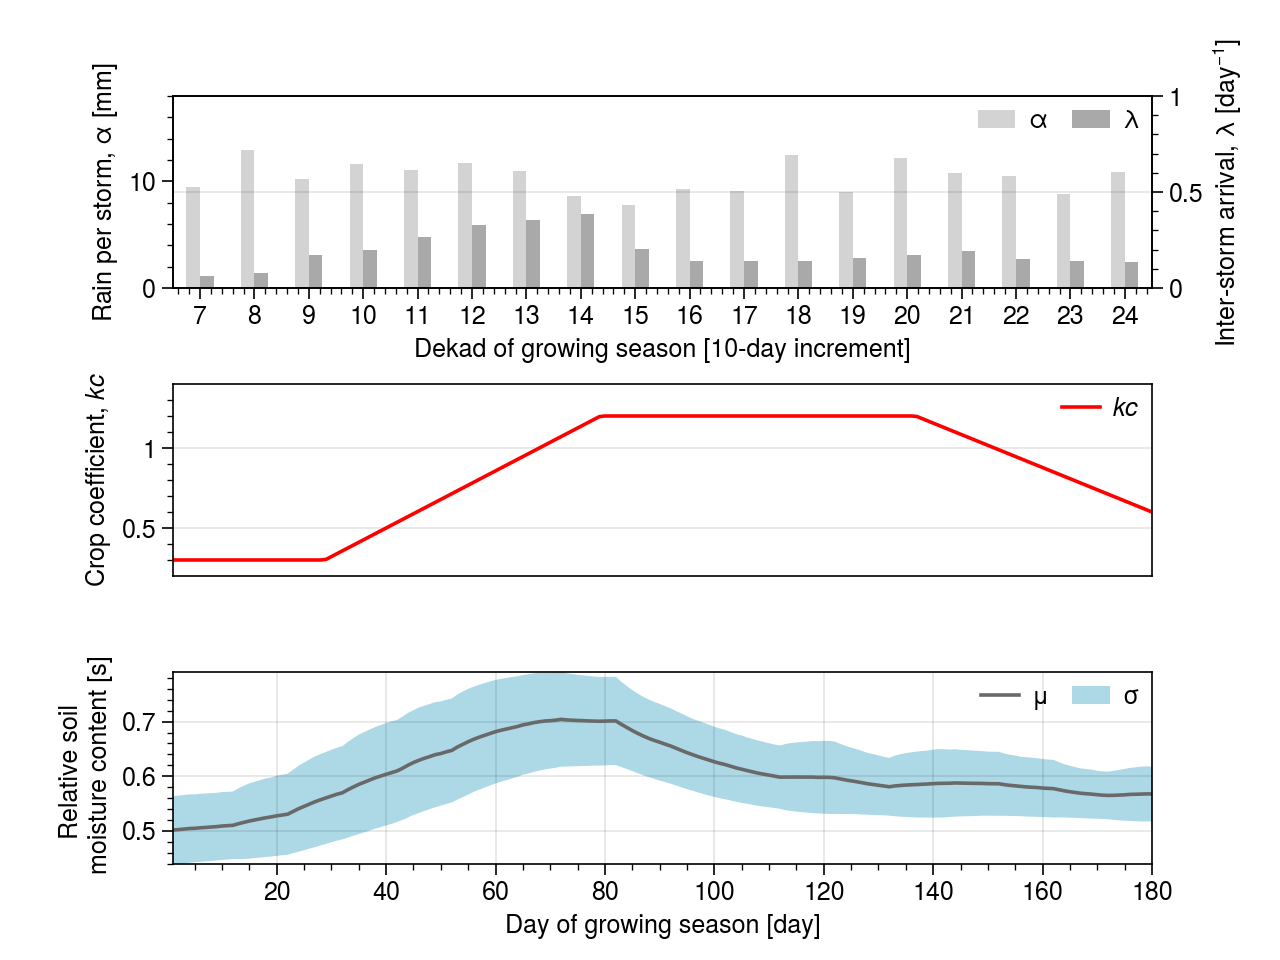

In [48]:
# this block does not like to be re-run
s0_climate = Climate(station='OL JOGI FARM', data_file='../data/CETRAD/CETRAD_rainfall.csv', interval='dekad')

# We want the unique values of alpha_r and lambda_r, so grab every 10th element of the list 
a = s0_climate.alpha_r[0::10]
l = s0_climate.lambda_r[0::10]

# make a dataframe
dekads = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'day':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})

# figure set up
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

#subset dataframe
dekads = dekads[6:24].set_index('dekad').drop(['day'], axis=1)

# plot the dekadal rainfall values
dekads.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray'])

ax1_ = ax1.twinx()
for r in ax1.patches[len(dekads):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ [mm]')
ax1_.set_ylabel('Inter-storm arrival, $\lambda$ [day$^{-1}$]')
#ax1.set_xlabel([], color='white')
ax1.legend([r'$\alpha$', r'$\lambda$'], ncol=2, frameon=False)
ax1.set_xlabel('Dekad of growing season [10-day increment]')
ax1_.set_xlabel([''])

ax1.grid(which='major',axis='both')

# Plot b) Crop Coefficient
#o = output[0]
#o.index = o.index+1 # make doy cooperate better

#climate = Climate(station='OL JOGI FARM', interval='dekad', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv')

#soil = Soil(texture='clay loam')
#crop = Crop(soil=soil, lgp=180)
#soil.set_nZr(crop)

#model = CropModel(crop=crop, climate=climate, soil=soil)
#model.run()
#o = model.output() # This is the correct length
#_kc = o[61:242]['kc']
_kc = output[1]['kc'] # use kc from actual output

ax2.plot(_kc, 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['$\mathit{kc}$'],frameon=False)
#ax2.tick_params(axis = "x", bottom = False, top = False)
ax2.xaxis.set_visible(False)


# Plot c) Saturation
output_s = pd.concat([d for d in output], axis=1) 
avg_df_180 = output_s['s'].dropna() 
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.std(axis=1)  # ddof=0, 

avg_df_180.index = avg_df_180.index+1 # make doy cooperate better

ax3.plot(avg_df_180['mean'], 'dimgray')

x = np.arange(1, 181, 1)
ax3.fill_between(x, avg_df_180['var']+avg_df_180['mean'], avg_df_180['mean']-avg_df_180['var'],facecolor='lightblue')
ax3.set(xlabel='Day of growing season [day]') # $\mathit{d}$
ax3.legend(['$\mu$','$\sigma$'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content [s]') # , $\mathit{s}$

plt.savefig('../output/high-res-figures-2/fig5_threefigs_dekadal.pdf')
plt.savefig('../output/high-res-figures-2/fig5_threefigs_dekadal.png',dpi=600)

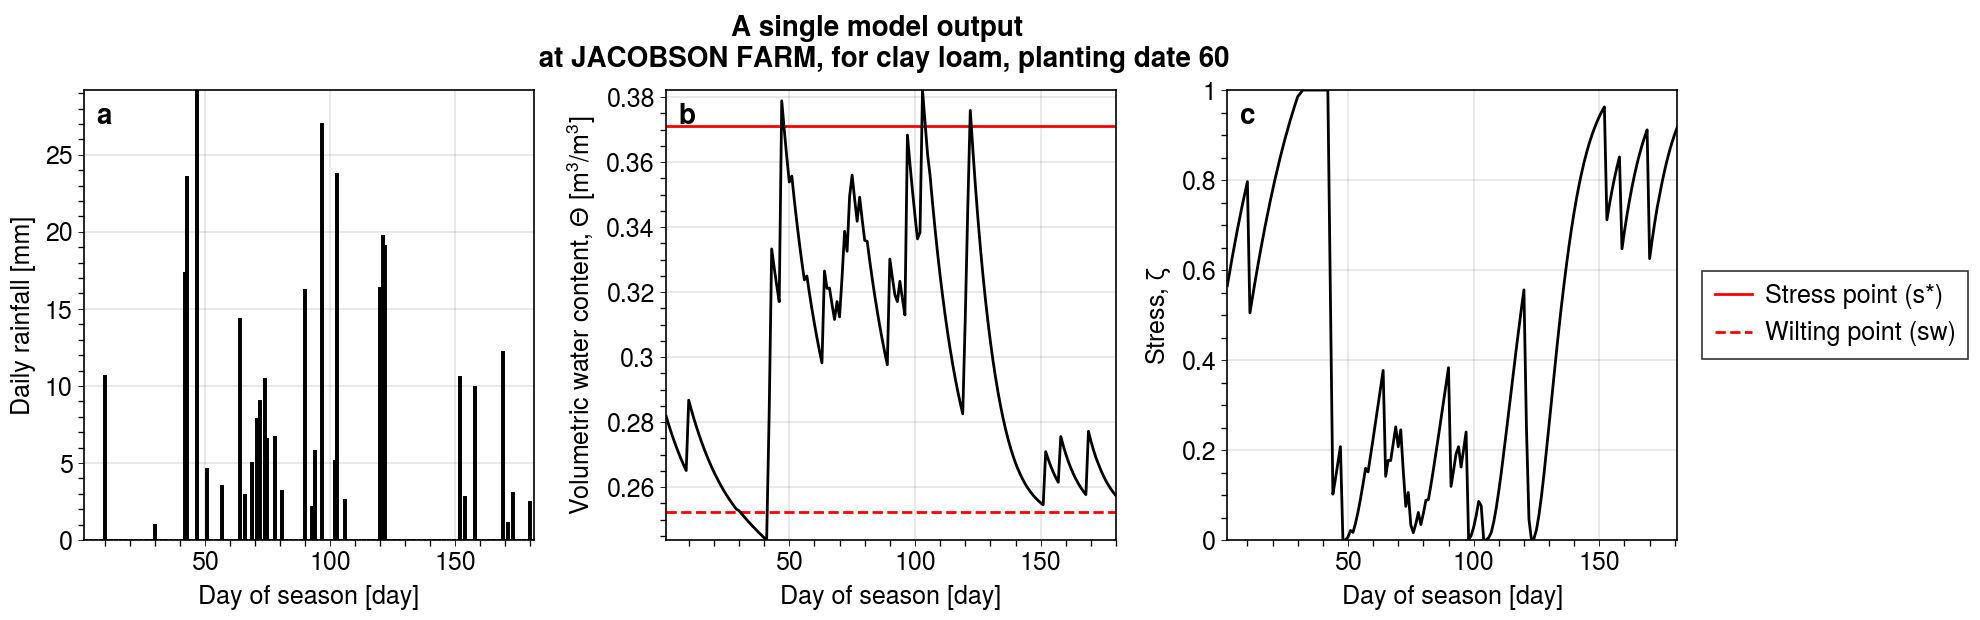

In [55]:
def figure6(output, avg_s):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function and generates time series figure

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='A single model output \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    #s_min = []
    #no_sims = np.arange(0,n_sim)
    
    #for i in no_sims:
    #    _s_min = output[i]['s'].min()
    #    s_min.append(_s_min)
    #result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    #lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    lowest = 13#1121 #1114
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest]['R']
    stress = output[lowest]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall [mm]')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of season [day]')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress, $\zeta$')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of season [day]')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content, $\Theta$ [m$^{3}$/m$^{3}$]')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of season [day]')
    #axs[0,1].format(xlim=(60, 240))
    plt.savefig('../output/high-res-figures-2/fig6_ts.png',format='png',dpi=600)

figure6(output, avg_s)

In [ ]:
# Figure 7
col = 'black'
f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
axs.format(abc=True, abcloc='ul')

# Figure a: Soil moisture distribution - converted
ax = axs[0,0]
avg_s_ = np.array(avg_s)*Soil(texture).n
sns.distplot(avg_s_, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
ax.format(ylabel='Probability density of volumetric water content, $p(\Theta)$') # r'p($\overline{vwc}$)
ax.format(xlabel='Volumetric water content, $\Theta$ [m$^{3}/m^{3}$]')

# Figure c: Stress distribution
ax = axs[1,0]
avg_stress = [df['stress'].mean() for df in output]
sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
ax.format(ylabel='Probability density of stress, $p(\zeta)$') # r'p($\overline{stress}$
ax.format(xlabel='stress, $\zeta$')

# Figure b: Soil moisture time series
avg_daily = pd.concat([df['s'] for df in output], axis=1); avg_daily
avg_daily = avg_daily*Soil(texture).n; avg_daily
avg_daily_t = avg_daily.T; avg_daily_t
daily_mean = avg_daily.mean(axis=1); daily_mean
#daily_mean.index = daily_mean.index # Change index so that we can see day of season; this used to be 1
daily_mean
#data = np.array(daily_mean)
x = np.arange(60, len(daily_mean)+60, 1)
axs[0,1].plot(x, daily_mean, color=col, lw=2)

# set custom x axis
#axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
#axs[0,1].format(xlabel='Day of season')
axs[0,1].format(xlabel='Day of year [day]')
axs[0,1].format(ylabel='Volumetric water content, $\Theta$ [m$^{3}/m^{3}$]')

# Figure d: Stress time series
avg_daily = pd.concat([df['stress'] for df in output], axis=1); avg_daily
#avg_daily = avg_daily*Soil(texture).n; avg_daily
avg_daily_t = avg_daily.T; avg_daily_t
daily_mean = avg_daily.mean(axis=1); daily_mean
#daily_mean.index = daily_mean.index # Change index so that we can see day of season; this used to be 1
daily_mean
#data = np.array(daily_mean)
x = np.arange(60, len(daily_mean)+60, 1)
axs[1,1].plot(x, daily_mean, color=col, lw=2)

# set custom x axis
#axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
axs[1,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
#axs[1,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
#axs[0,1].format(xlabel='Day of season')
axs[1,1].format(xlabel='Day of year [day]')
axs[1,1].format(ylabel='stress, $\zeta$')
plt.savefig('../output/high-res-figures-2/fig7_PDFs.png',format='png',dpi=300)

#print('s star',_sstar,'sw',_sw)

In [27]:
stress = pd.concat([df['stress'] for df in output], axis=1)
stress_t = stress.T
daily_mean = stress.mean(axis=1)
daily_mean.index = daily_mean.index + 1
data = np.array(daily_mean)

2.7627602813688767


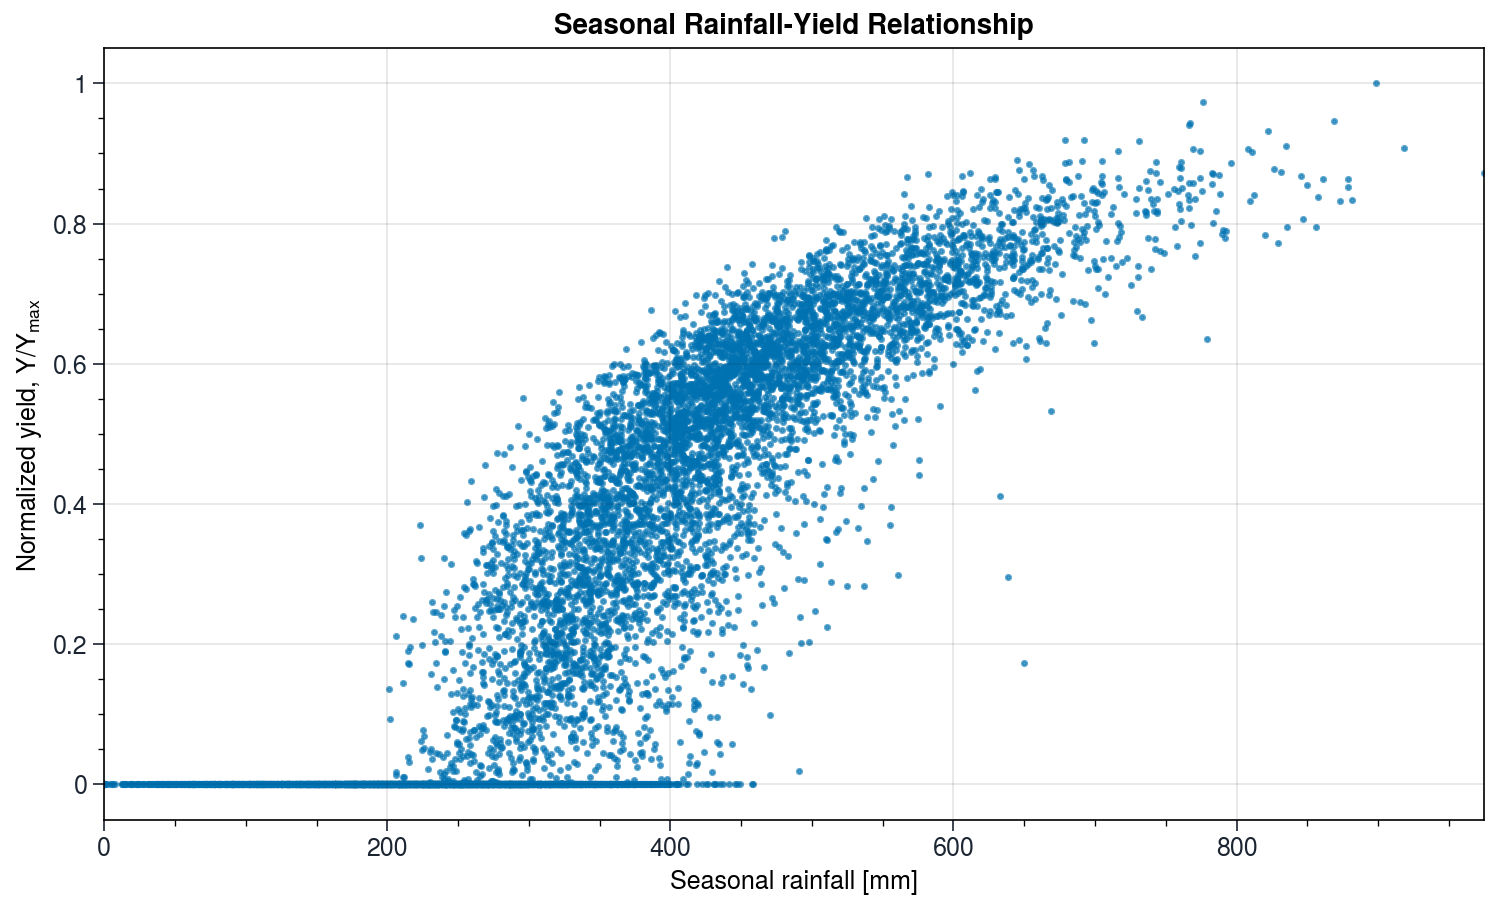

In [57]:
# Figure 8. Dynamic Stress-Rainfall-Yield Relationship

# line up the data
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output]
rf = [df['R'].sum() for df in output]
    
# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
print(max(df.Yield)/1000)

# Dynamic Stress Yield Rlxn

def fig8(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    # Y axis can either be nornalized yield or yield
    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Seasonal Rainfall-Yield Relationship')
    
    cols = 'dark'
    
    plt.scatter(df.RF, df.Yield_norm, alpha=0.6, size=2.5) # , color='blue' # , color='black'
    plt.ylim(-.05,1.05)
    plt.ylabel('Normalized yield, $Y/Y_{max}$ ') # Yield normalized by max. yield
    plt.xlabel('Seasonal rainfall [mm]')
    plt.savefig('../output/high-res-figures-2/fig8_dyn-stress.png',format='png',dpi=300)
    plt.savefig('../output/high-res-figures-2/fig8_dyn-stress.pdf')
    
    axs.tick_params(axis='y', colors=cols)
    axs.tick_params(axis='x', colors=cols)
    
fig8(df=df)

In [29]:
# # Fig. 9 Cultivar PDF

def cultivar_runs():

    # Now I have to re-run the simulations using the max yields from this relationship
    varieties = np.arange(75,180,5)
    len(varieties)

    result = []

    for i in varieties:
        # note: bumping up to 200 sims per cultivar type takes several minutes to run
        # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
        #data, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(alpha_r =a_mid, lambda_r= l_mid, n_sim=500, station='OL JOGI FARM', texture='clay loam', lgp=i, pd_sim=60)
        data, rf, lgp, avg_s, output_orig, crop, station, texture, pd_sim, n_sim, burn_in, start, end = run(alpha_r =a_mid, lambda_r= l_mid, n_sim=500, station='OL JOGI FARM', texture='clay loam', lgp=i, pd_sim=60)
        df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
        df['RF'] = rf
        df['Cultivar'] = i
        result.append(df)
        
    return result

result = cultivar_runs()
result = pd.concat(result)

# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this
def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"

for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))



Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 75 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 50
	...Computing average soil moisture for doy 365 using 50 simulations
		[s0_mean]:0.41204808106749846	[s0_std]:0.08926851609509615
Step 4: 
	... Running 500 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 125 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 50
	...Computing average soil moisture for doy 365 using 50 simulations
		[s0_mean]:0.4148484377505826	[s0_std]:0.09807490567811761
Step 4: 
	... Running 500 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plan

		[s0_mean]:0.4105526044443311	[s0_std]:0.08654093944661607
Step 4: 
	... Running 500 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 175 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 50
	...Computing average soil moisture for doy 365 using 50 simulations
		[s0_mean]:0.4221456859934416	[s0_std]:0.07609446175717688
Step 4: 
	... Running 500 simulations.
Progress: |██████████████████████████████████████████████████| 100.0

In [30]:
#result.to_csv('../output/high-res-figures/cultivar_sims/result.csv',sep=',')
#result.to_csv('../output/revisions/result.csv',sep=',')
result.to_csv('../output/revisions/result.3.23.21.csv',sep=',')

In [60]:
#result = pd.read_csv('../output/high-res-figures/cultivar_sims/result.csv', sep=',').drop('Unnamed: 0', axis=1)
#result = pd.read_csv('../output/revisions/result.csv', sep=',').drop('Unnamed: 0', axis=1)
result = pd.read_csv('../output/revisions/result.3.23.21.csv', sep=',').drop('Unnamed: 0', axis=1)


In [61]:
# for average yield need to take non-zero numbers
r0=result
r0[r0 == 0] = np.nan

early = r0.query("Category == 'Early (< 105 d)'")
med = r0.query("Category == 'Medium (110 - 140 d)'")
late = r0.query("Category == 'Late (145 + d)'")

# need to use nan mean for Yield because 0s were turned into nans
e_rf, e_y = early.RF.mean(), np.nanmean(early.Yield)
m_rf, m_y = med.RF.mean(), np.nanmean(med.Yield)
l_rf, l_y = late.RF.mean(), np.nanmean(late.Yield)

# Turn nans back to zeros
early = early.fillna(0)
med = med.fillna(0)
late = late.fillna(0)

# Percent of crop failure - calc before turning nans to zero
c_e = len(early.loc[early['Yield'] == 0].count(axis=1))/len(early)*100
c_m = len(med.loc[med['Yield'] == 0].count(axis=1))/len(med)*100
c_l = len(late.loc[late['Yield'] == 0].count(axis=1))/len(late)*100

# code for ticks
import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))
cbar_kws={'format': mticker.FuncFormatter(g)}

In [62]:
# Make the table 

# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Early (< 105 d)','Medium (110 - 140 d)',  'Late (145 + d)']
rf = [e_rf, m_rf, l_rf]
y = [e_y, m_y, l_y]
c = [c_e, c_m, c_l]

table1 = pd.DataFrame({'Maize Variety':p_desc,
                       'Average Rainfall (mm)': rf,
                       'Average Yield (t/ha)': y,
                       'Probability of Crop Failure (%)':c})

table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
             'Probability of Crop Failure (%)':2})
#table1.to_csv('table1.csv',sep=',')

print(table1.to_latex(index=False))
table1

\begin{tabular}{lrrr}
\toprule
        Maize Variety &  Average Rainfall (mm) &  Average Yield (t/ha) &  Probability of Crop Failure (\%) \\
\midrule
      Early (< 105 d) &                  209.4 &                1.0920 &                            29.37 \\
 Medium (110 - 140 d) &                  265.7 &                1.1228 &                            35.14 \\
       Late (145 + d) &                  322.0 &                1.2534 &                            39.46 \\
\bottomrule
\end{tabular}



,Maize Variety,Average Rainfall (mm),Average Yield (t/ha),Probability of Crop Failure (%)
0,Early (< 105 d),209.4,1.0920,29.37
1,Medium (110 - 140 d),265.7,1.1228,35.14
2,Late (145 + d),322.0,1.2534,39.46


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, a

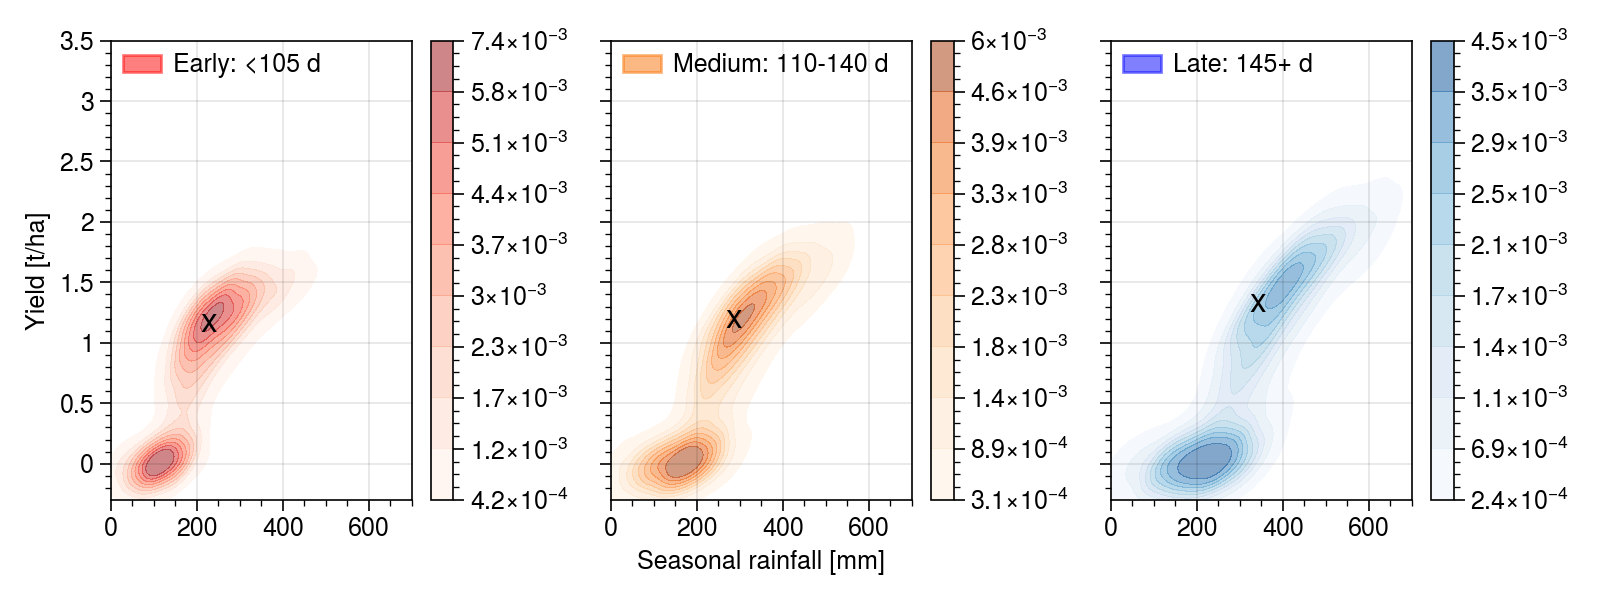

In [63]:
def fig_9():

    # I dont know how to do this with proplot - to get nice abcd, put in an issue
    fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) 

    # Labels, ticker
    import matplotlib.patches as mpatches
    import matplotlib.ticker as mticker


    red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
    orange_patch = mpatches.Patch(color='orange', label='Medium: 110-140 d', alpha=0.5)
    blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)

    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))


    sns.kdeplot(early.RF, early.Yield, xlim=(0,700),ylim=(-0.3,3.5), alpha=0.5, kind='kde',cmap="reds", shade=True, 
                    shade_lowest=False, cbar=True, ax=axes[0], label='early', cbar_kws={'format': mticker.FuncFormatter(g)})
    ax1 = axes[0]
    ax1.text(e_rf,e_y, "x", size=12, color='k')
    ax1.set(ylabel='Yield [t/ha]')
    ax1.set(xlabel='')
    ax1.legend(handles=[red_patch],loc='upper left', frameon=False)
    ax1.set(ylim=(-0.3,3.5))

    #plt.show()
    ax2 = axes[1]
    sns.kdeplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.3,3.5),alpha=0.5,kind='kde',cmap="oranges", 
                      shade=True, shade_lowest=False, cbar=True,ax=ax2, cbar_kws={'format': mticker.FuncFormatter(g)})
    ax2.text(m_rf,m_y,"x",size=12,color='k')
    ax2.set(xlim=(0,700))
    ax2.set(ylabel='')
    ax2.set(xlabel='Seasonal rainfall [mm]')
    ax2.legend(handles=[orange_patch],loc='upper left', frameon=False)


    ax3 = axes[2]
    #plt.show()
    sns.kdeplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.3,3.5), alpha=0.5,kind='kde',cmap="blues", shade=True, shade_lowest=False, cbar=True, ax=ax3, cbar_kws={'format': mticker.FuncFormatter(g)}) #greens
    ax3.text(l_rf,l_y, "x", size=12, color='k')
    ax3.set(ylabel='')
    ax3.set(xlabel='')
    ax3.legend(handles=[blue_patch],loc='upper left', frameon=False)

    fig.tight_layout()
    plt.savefig('../output/high-res-figures-2/fig9_varietiesPDF.pdf')
    plt.savefig('../output/high-res-figures-2/fig9_varietiesPDF.png',dpi=300)
    
fig_9()

In [35]:
# Three eras PDF - this code is taking from 2-past-cropping-outcomes and is much better commented there

## Steps:

#### 1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.

# These values are from the trend graphs in `1-rainfall-variability-stats`.

# Make a plot of the slopes for Jacobson Farm for alpha and lambda
t = pd.Series(np.arange(1934, 2015, 1))

# Import these trends but based on 5 month parameters (This is taking the average of the long rains and short rains)
m_a = 0.066401 # Slope, alpha
m_l = -0.002440 # Slope, lambda

c_a = -122.684507 # Intercept, alpha
c_l = 5.163470 # Intercept, lambda

#### 2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)

# Seasonally varying component = alpha and lambdas as they stand normally in the code.

# This is for Jacobson Farm
station = 'JACOBSON FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
# These will be our alphas and lambdas for the middle of the time series                                                                              ]})
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

#### 3. Those average decad values would correspond to the typical climate in the middle of the record.

# Use those values for alpha, `a_mid`, and lambda, `l_mid`, as the typical climate in the middle of the record. Run the models.

In [36]:
x, rf, lgp, avg_s, output_mid, crop, station, texture, pd_sim, n_sim, burn_in, start, end = run2(station='JACOBSON FARM',
    alpha_r =a_mid, lambda_r= l_mid, n_sim=10000)

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5303522564998089	[s0_std]:0.08158600214585153
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [37]:
# put into dataframe
result = pd.DataFrame.from_records(x, columns =['AvgStress','DynamicStress','Yield'])
result['RF'] = rf

# For catting them all together
result['Era'] = 'mid'

In [38]:
#### 4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.

# There are 80 years in the record (1934-2014), so we'll add or subtract by 40 years.
# df_mid corresponds to the alpha and lambdas we use for the middle or average values
# previously used m_al, m_ll but now can just use m_l and m_a

alphas_2010 = df_mid['alpha']+m_a*40; alphas_2010
alphas_1930 = df_mid['alpha']-m_a*40; alphas_1930

lambdas_2010 = df_mid['lambda']+m_l*40; lambdas_2010 
lambdas_1930 = df_mid['lambda']-m_l*40

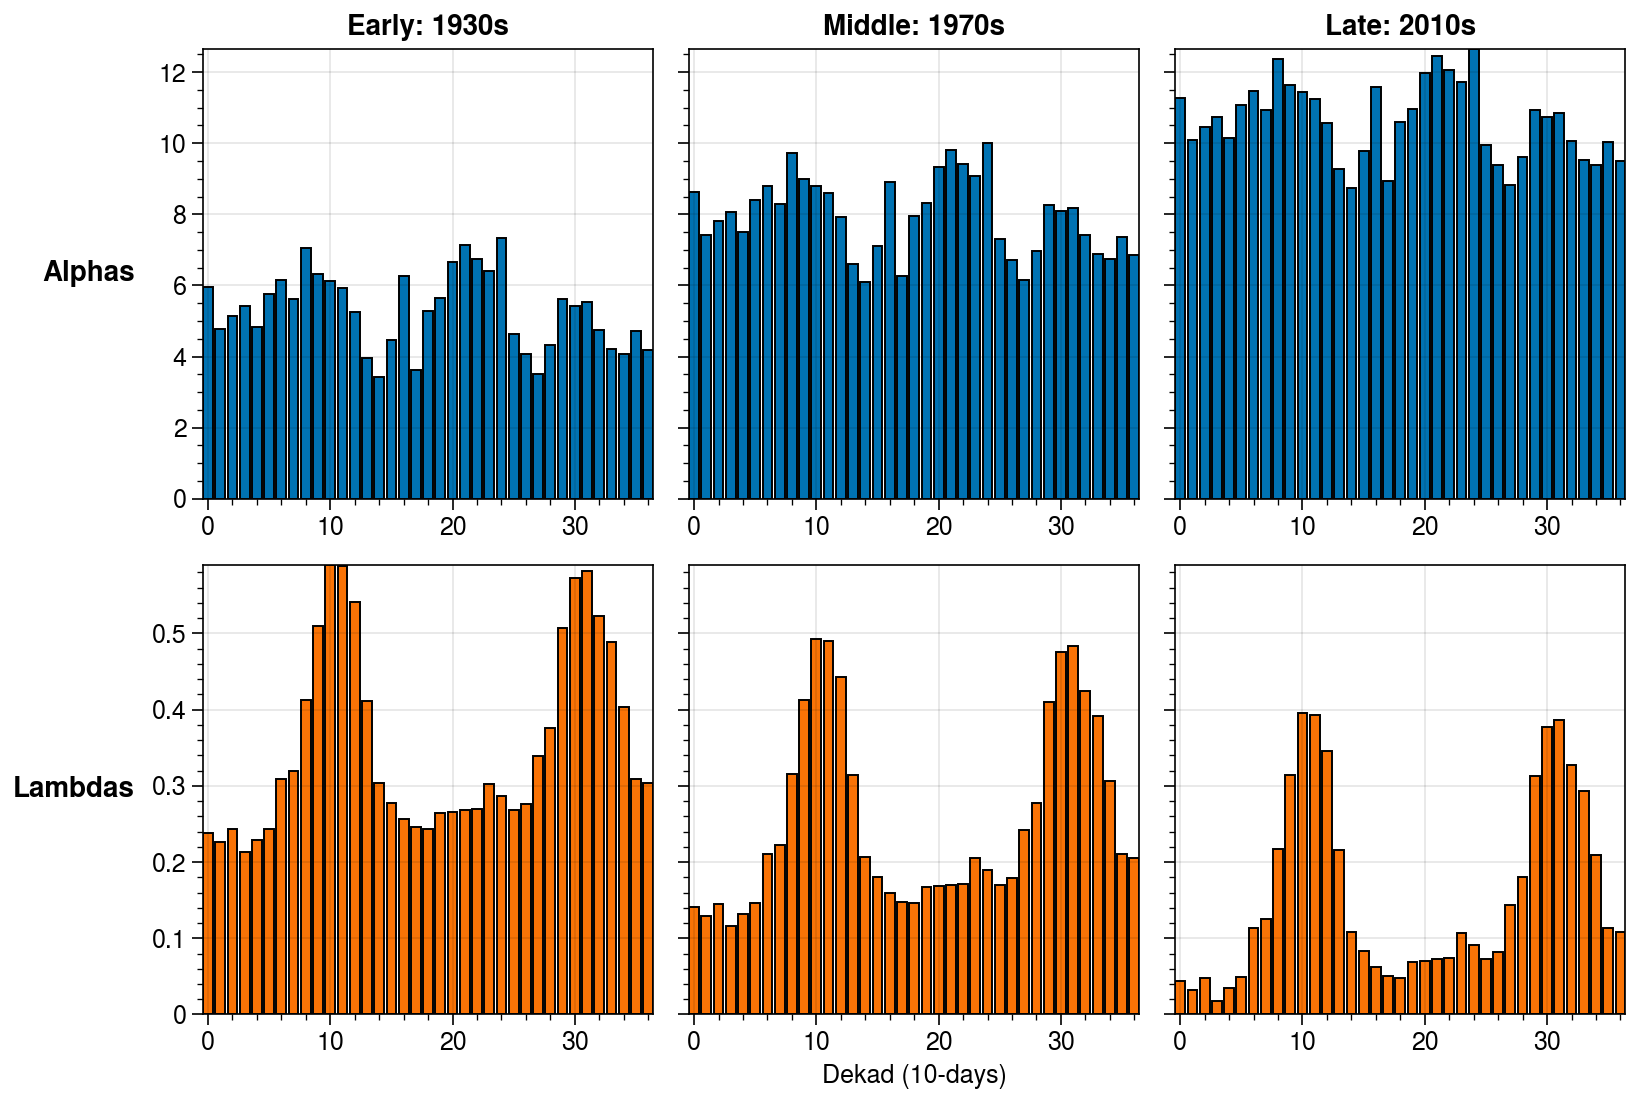

In [39]:
# Make three bar subplots of the deakadal alphas and lambdas
f, ax = plot.subplots(nrows=2, ncols=3, sharex=True) # , sharey=1

ax.format(
    rowlabels=['Alphas', 'Lambdas'],
    collabels=['Early: 1930s', 'Middle: 1970s', 'Late: 2010s']
)

ax[0,0].bar(alphas_1930)
ax[0,1].bar(df_mid.alpha)
ax[0,2].bar(alphas_2010)

ax[1,0].bar(lambdas_1930, color='orange')
ax[1,1].bar(df_mid['lambda'], color='orange')
ax[1,2].bar(lambdas_2010, color='orange')

# Good ol labels
#ax[0:].format(ylabel='Avg. depth per storm (mm)')
#ax[1:].format(ylabel='Inter-storm arrival rate (day^-1)')
ax[:3:2].format(xlabel='Dekad (10-days)')
ax[1:].format(ylabel='')

In [40]:
# Run the sims for 2010
x_late, rf, lgp, avg_s, output_late, crop, station, texture, pd_sim, n_sim, burn_in, start, end = run2(alpha_r=alphas_2010, 
    lambda_r=lambdas_2010,n_sim=10000, station='JACOBSON FARM')

# put into dataframe
result_2010 = pd.DataFrame.from_records(x_late, columns =['AvgStress','DynamicStress','Yield'])
result_2010['RF'] = rf
result_2010['Era'] = 'late'

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5283989025858361	[s0_std]:0.08041623927371251
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [41]:
# Run the sims for 1930s
x_early, rf, lgp, avg_s, output_early, crop, station, texture, pd_sim, n_sim, burn_in, start, end = run2(
    alpha_r=alphas_1930, lambda_r=lambdas_1930,n_sim=10000, station='JACOBSON FARM')

# put into dataframe
result_1930 = pd.DataFrame.from_records(x_early, columns =['AvgStress','DynamicStress','Yield'])
result_1930['RF'] = rf
result_1930['Era'] = 'early'

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
Laikipia station data was inputted.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5275648187608872	[s0_std]:0.07868456419567463
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [42]:
# # Cat the three dataframes together
# I have a sneaky suspicion its this
result_list = [result_1930, result, result_2010]
result_list = pd.concat(result_list)
result_list

,AvgStress,DynamicStress,Yield,RF,Era
0,0.530674,1.000000,0.000000,352.857531,early
1,0.446987,0.810743,0.816752,485.946804,early
2,0.913609,1.000000,0.000000,130.694256,early
3,0.938218,1.000000,0.000000,100.826128,early
4,0.565044,1.000000,0.000000,346.634847,early
...,...,...,...,...,...
9995,0.595301,1.000000,0.000000,290.047228,late
9996,0.710862,1.000000,0.000000,168.840410,late
9997,0.617474,0.987045,0.055909,299.563988,late
9998,0.525401,0.606104,1.699886,698.348117,late


In [43]:
#export result_list
#result_list.to_csv('../output/high-res-figures/eras_sims/result.csv',sep=',')
result_list.to_csv('../output/revisions/eras_result-2.csv',sep=',')

In [44]:
#result_list = pd.read_csv('../output/high-res-figures/eras_sims/result.csv',sep=',').drop(['Unnamed: 0'], axis=1).fillna(0)
result_list = pd.read_csv('../output/revisions/eras_result-2.csv',sep=',').drop(['Unnamed: 0'], axis=1).fillna(0)

In [45]:
# Do table and plot

def make_table(df = None):
    
    # set up three eras
    r_1930 = df.query('Era == "early"')
    r_avg = df.query('Era == "mid"')
    r_2010 = df.query('Era == "late"')
    
    # need alphas and lambdas to be set to 180d
    # We want dekad 7 through 25
    a_1930 = alphas_1930[6:26] # zero-index
    a_avg = a_mid[6:24]
    a_2010 = alphas_2010[6:24]
    
    l_1930 = lambdas_1930[6:24] # zero-index
    l_avg = l_mid[6:24]
    l_2010 = lambdas_2010[6:24]
    table = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
                       # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
                'Maize Variety':[180,180,180],
                'Average Seasonal Alpha (mm)':[mean(a_1930), mean(a_avg), mean(a_2010)],
                'Average Seasonal Lambda (day^-1)':[mean(l_1930), mean(l_avg), mean(l_2010)],
                
                'Average Seasonal Rainfall (mm)':[r_1930.RF.mean(), r_avg.RF.mean(), r_2010.RF.mean()],
                          
                'SD Seasonal  Rainfall':[np.std(r_1930.RF),np.std(r_avg.RF),np.std(r_2010.RF)],
                          
                'CV Seasonal Rainfall':[r_1930.RF.std()/r_1930.RF.mean(), 
                                    r_avg.RF.std()/r_avg.RF.mean(),
                                    r_2010.RF.std()/r_2010.RF.mean()],
                'Average Yield (t/ha)': [np.nanmean(r_1930.Yield), 
                                         np.nanmean(r_avg.Yield), 
                                         np.nanmean(r_2010.Yield)],
                'Probability of Crop Failure (%)':[len(r_1930.loc[r_1930['Yield'] == 0].count(axis=1))/len(r_1930)*100,
                                                   len(r_avg.loc[r_avg['Yield'] == 0].count(axis=1))/len(r_avg)*100,
                                                   len(r_2010.loc[r_2010['Yield'] == 0].count(axis=1))/len(r_2010)*100]})
    return table

table = make_table(result_list); table

,Rainfall Climatology,Maize Variety,Average Seasonal Alpha (mm),Average Seasonal Lambda (day^-1),Average Seasonal Rainfall (mm),SD Seasonal Rainfall,CV Seasonal Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.706883,0.354322,361.474186,138.426899,0.38297,0.557931,54.04
1,Middle: 1970s (Avg),180,8.331615,0.256722,386.321353,153.508551,0.39738,0.853189,35.24
2,Late: 2010s,180,10.987655,0.159122,315.880913,133.781613,0.42354,0.635196,40.99


In [46]:
result_list[result_list == 0] = np.nan

result_early = result_list.query('Era == "early"')
result_mid = result_list.query('Era == "mid"')
result_late = result_list.query('Era == "late"')

# for average yield need to take non-zero numbers

# need to use nan mean for Yield because 0s were turned into nans
e_rf, e_y = result_early.RF.mean(), np.nanmean(result_early.Yield)
m_rf, m_y = result_mid.RF.mean(), np.nanmean(result_mid.Yield)
l_rf, l_y = result_late.RF.mean(), np.nanmean(result_late.Yield)

# Turn nans back to zeros
result_early = result_early.fillna(0)
result_mid = result_mid.fillna(0)
result_late = result_late.fillna(0)

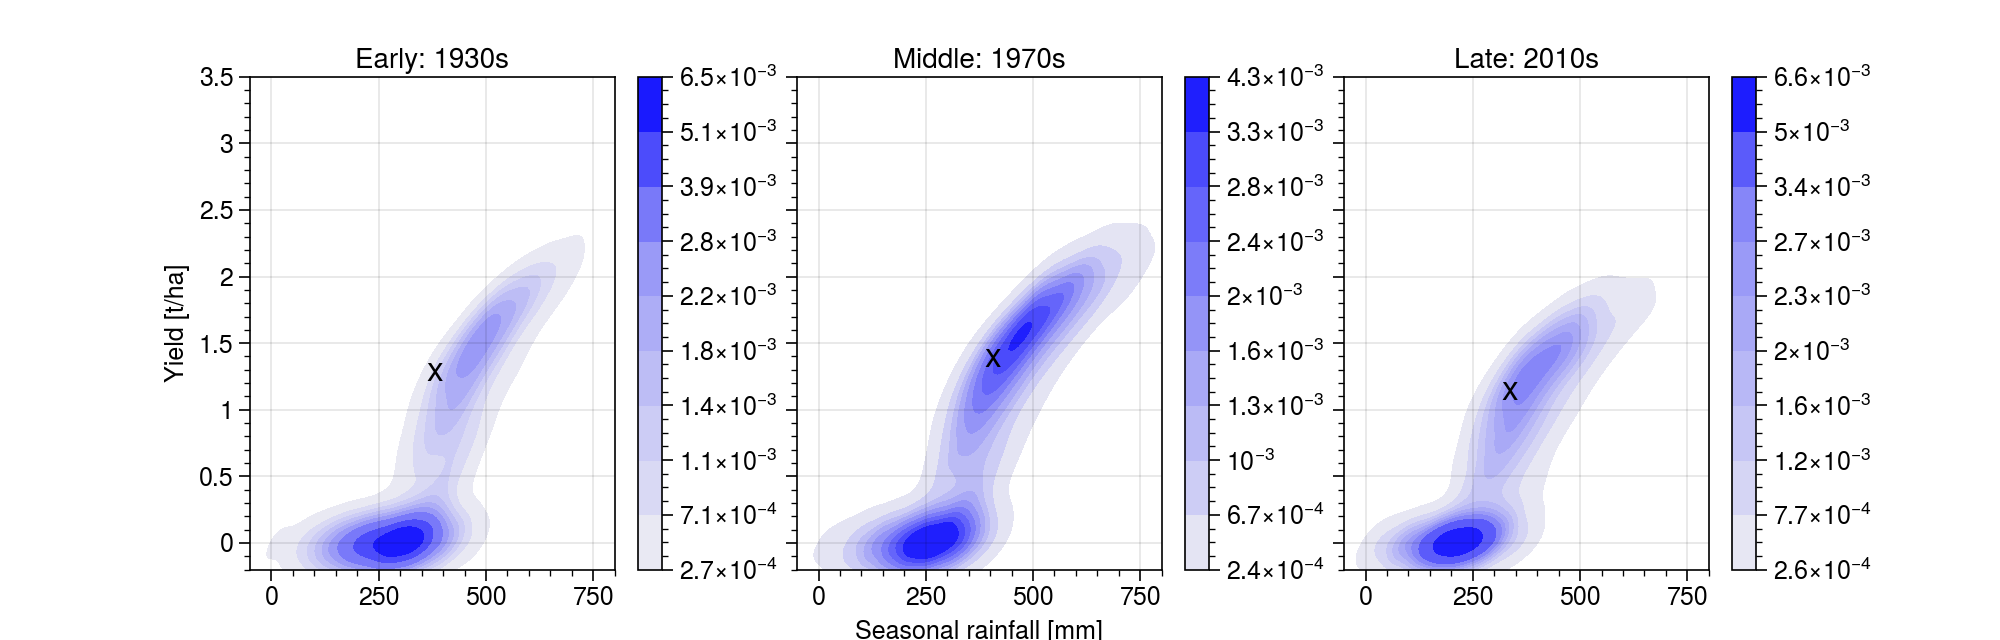

In [59]:
def fig_10():
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.2), sharey=True, sharex=True)

    # Set colorscheme
    blues = sns.color_palette("light:b", as_cmap=True)
    col = 'black'

    # For sci notation
    import matplotlib.ticker as mticker
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

    # Draw plots
    ax1 = ax[0]
    sns.kdeplot(data=result_early, x="RF", y="Yield", cmap=blues,cbar=True, shade = True,
                ax=ax1, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Early: 1930s')

    ax1.text(e_rf,e_y, "x", size=12, color=col)

    ax2 = ax[1]
    sns.kdeplot(data=result_mid, x="RF", y="Yield",cmap=blues, shade=True,
                     cbar=True,ax=ax2, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Middle: 1970s')
    ax2.text(m_rf,m_y, "x", size=12, color=col)

    ax3 = ax[2]
    sns.kdeplot(data=result_late, x="RF", y="Yield", cmap=blues, shade=True,
                 cbar=True, ax=ax3, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Late: 2010s')

    ax3.text(l_rf,l_y, "x", size=12, color=col)
    # Set labels
    ax1.set(xlabel='')
    ax1.set(ylabel='Yield [t/ha]')
    ax2.set(xlabel='Seasonal rainfall [mm]')
    ax2.set(ylabel='')
    ax3.set(ylabel='')
    ax3.set(xlabel='')

    # Set axes limits
    for ax in [ax1, ax2, ax3]:
        ax.set(ylim=(-0.2,3.5))
        ax.set(xlim=(-50,800))
        
    plt.savefig('../output/high-res-figures-2/fig10_erasPDF.pdf')
    plt.savefig('../output/high-res-figures-2/fig10_erasPDF.png',dpi=300)

fig_10()